In [1]:
%load_ext autoreload
%autoreload 2

#todo:
- make mice_ia_pipeline file
- link google collab to notebook

# intro and overview

Goal is to assign intrinsic shear components

IA modeling works in three steps:
1. modeling galaxy 3D shapes
2. modeling galaxy 3D orientations
3. project 3D objects along the observes line of sight to obtain the 2D ellipticities

The code is vectorize to enable parallel execution on large data sets using Spark.

outline:
- read data
- initialize paramters
- model shapes
- model orientations

In [2]:
# pip install ipykernel pandas numpy pyarrow scipy matplotlib

In [3]:
import pkg_resources

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from genial import Galaxy, IntrinsicAlignment

pd.set_option("display.max_columns", 50)

# 1) set IA model parameters


### define u-r color cut
The $u-r=M_u-M_r$ is the color index, defined via the absolute resframe magnitudes $M_u$ and $M_r$ in the u- and r-band. This cut is used to define the color-type of a given galaxy (red or blue). In this verison of the IA model the color-type defines which parameters are used to model galaxy shapes as well as galaxy-halo misalignment.

In [4]:
ia_ur_cut = 0.94

### set parameters for galaxy-halo misalignemnt
These parameters define the linear magnitude dependence of the misalignment parameter $\sigma (M_r)$ used of the IA modeling in MICE

In [5]:
# red centrals and satellites
p_cr, p_sr = [0.65, 0,0], [0.7, -7.7]

# blue centrals and satellites
p_cb, p_sb = [2.0, 0.0],  [2.0, 0.0]

### read parameters for modeling galaxy axis ratios from input table

Table containing the interpolated parameters of the galaxy shape model in narrow redshift and magnitude bins
for red and blue galaxies

In [6]:
with open('ia_shape_parameters.csv') as fd:

    ia_params = pd.read_csv(fd, header=0)
    
    #set color IDs for red and blue in the input table to those used in the galaxy class
    ia_params.loc[ia_params['gal_color']==2.0, 'gal_color'] = Galaxy.Color.BLUE.value
    ia_params.loc[ia_params['gal_color']==0.0, 'gal_color'] = Galaxy.Color.RED.value
    
    #put table into format that can be passed to the IA class
    ia_params = ia_params.set_index(['gal_color', 'z', 'mag']).sort_index()[['q_mean', 'r_mean', 'sigma']]

# 2) read input galaxy catalogue

Required columns of input file:
- x_gal, y_gal, z_gal (galaxy positions)
- x_halo, y_halo, z_halo (halo positions)
- Ax_halo, Ay_halo, Az_halo (halo major axis components)
- Cx_halo, Cy_halo, Cz_halo (halo minor axis components)
- Jx_halo, Jy_halo, Jz_halo (halo angular momentum components)
- u- and r-band absolute restframe magnitudes
- flag_central (some flag, defining a galaxy as central or satellite)

Here we use an input file generated from the MICE IA catalog on cosmohub.pic.es, using this SQL query

SELECT `x_gal`, `y_gal`, `z_gal`, `flag_central`, `true_redshift_gal`, `cfht_u_abs_mag`, `subaru_r_abs_mag`,`x_halo`, `y_halo`, `z_halo`, `ax_halo`, `ay_halo`, `az_halo`, `cx_halo`, `cy_halo`, `cz_halo`, `jx_halo`, `jy_halo`, `jz_halo` FROM mice2_ia_20210203_c WHERE true_redshift_gal < 0.2 AND subaru_r_abs_mag - 0.8 * (ATAN(1.5 * true_redshift_gal) - 0.1489) < -21

In [7]:
cat = pd.read_parquet('12049.parquet')#.iloc[0:1000]

### inspect data

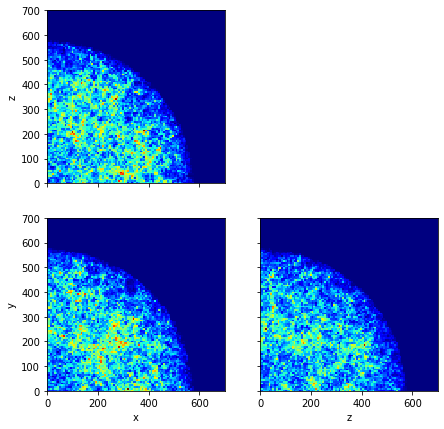

In [8]:
fig, ax = plt.subplots(2,2,figsize=(7,7), sharex=True, sharey=True)

cmap='jet'

lbins=np.linspace(0,700,100)


ax[0,0].hist2d(cat.x_gal, cat.z_gal, bins=[lbins,lbins], cmap=cmap)
ax[1,0].hist2d(cat.x_gal, cat.y_gal, bins=[lbins,lbins], cmap=cmap)
ax[1,1].hist2d(cat.z_gal, cat.y_gal, bins=[lbins,lbins], cmap=cmap)
ax[0,1].axis('off')

ax[0,0].set_ylabel('z')
ax[1,0].set_ylabel('y')
ax[1,0].set_xlabel('x')
ax[1,1].set_xlabel('z')

plt.show()

### define galaxy color IDs

In [9]:
#### use this color index for red blue definitions
ia_ur = cat['cfht_u_abs_mag'] - cat['subaru_r_abs_mag']

# Apply color cut to define color
ia_color = np.where(
    ia_ur < ia_ur_cut,
    Galaxy.Color.BLUE.value,
    Galaxy.Color.RED.value
).astype('i1')

### define satellite / central IDs

In [10]:
# Apply color cut to define color
ia_kind = np.where(
    cat.flag_central == 0,
    Galaxy.Kind.CENTRAL.value,
    Galaxy.Kind.SATELLITE.value
).astype('i1')

# 3) assign 3D galaxy shapes

### instance of IA class

In [11]:
ia = IntrinsicAlignment(ia_params)

### set 3D axis ratios q=B/A, s=C/A

In [12]:
cat['q_gal'], cat['s_gal'] = ia.axis_ratio(ia_color, cat['true_redshift_gal'].values, cat['subaru_r_abs_mag'].values)

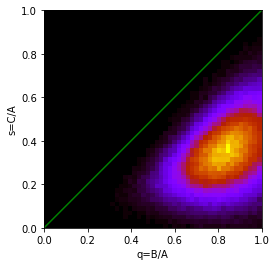

In [14]:
sq_bins = np.linspace(0,1,50)
plt.hist2d(cat.q_gal, cat.s_gal,bins=sq_bins, cmap='gnuplot')
plt.plot(sq_bins, sq_bins, c='g')
plt.axis('square')
plt.xlabel('q=B/A')
plt.ylabel('s=C/A')
plt.show()

# 4) assign 3D galaxy orientations

### make sure that vectors of halo major and minor axis and angular momentum are normalized

In [15]:
cat['a_halo'] = ((cat['ax_halo']**2 + cat['ay_halo']**2 + cat['az_halo']**2)**0.5)
cat['c_halo'] = ((cat['cx_halo']**2 + cat['cy_halo']**2 + cat['cz_halo']**2)**0.5)
cat['j_halo'] = ((cat['jx_halo']**2 + cat['jy_halo']**2 + cat['jz_halo']**2)**0.5)

cat['ax_halo'] = (cat['ax_halo'] / cat['a_halo'])
cat['ay_halo'] = (cat['ay_halo'] / cat['a_halo'])
cat['az_halo'] = (cat['az_halo'] / cat['a_halo'])

cat['cx_halo'] = (cat['cx_halo'] / cat['c_halo'])
cat['cy_halo'] = (cat['cy_halo'] / cat['c_halo'])
cat['cz_halo'] = (cat['cz_halo'] / cat['c_halo'])

cat['jx_halo'] = (cat['jx_halo'] / cat['j_halo'])
cat['jy_halo'] = (cat['jy_halo'] / cat['j_halo'])
cat['jz_halo'] = (cat['jz_halo'] / cat['j_halo'])

### set up input vectors for IA model

In [68]:
vg = np.array([
    cat['x_gal'].values,
    cat['y_gal'].values,
    cat['z_gal'].values,
]).T

vh = np.array([
    cat['x_halo'].values,
    cat['y_halo'].values,
    cat['z_halo'].values,
]).T
    
Ah = np.array([
    cat['ax_halo'].values,
    cat['ay_halo'].values,
    cat['az_halo'].values,
]).T

Ch = np.array([
    cat['cx_halo'].values,
    cat['cy_halo'].values,
    cat['cz_halo'].values,
]).T
  
Jh = np.array([
    cat['jx_halo'].values,
    cat['jy_halo'].values,
    cat['jz_halo'].values,
]).T

In [98]:
satellites.shape, AG_zero.shape

((229131,), (1, 229131))

In [108]:
satellites_Ag_zero = satellites & (np.linalg.norm(Ag, axis=1)[:,None]==0).T[0]

In [109]:
satellites_Ag_zero.shape, Ag.shape

((229131,), (229131, 3))

In [110]:
Ag[satellites_Ag_zero==True]

array([], shape=(0, 3), dtype=float64)

In [116]:
satellites_Ag_zero = satellites & (np.linalg.norm(Ag, axis=1)[:,None]==0).T[0]

In [117]:
Ag[satellites_Ag_zero==False]

array([[-0.02102466, -0.84566402,  0.53330135],
       [-0.09520752,  0.72475906,  0.68239272],
       [ 0.6175195 , -0.70681843, -0.3450759 ],
       ...,
       [ 0.45060955,  0.30501834, -0.83899633],
       [-0.10617593, -0.75866239,  0.64277371],
       [-0.13619131,  0.81530901,  0.56278161]])

### set initial orientations

In [19]:
Ag, Cg = ia.orientations(ia_kind, ia_color, vg, vh, Ah, Ch, Jh)

In [33]:
satellites.shape, zero_norm.shape

((229131,), (1, 229131))

In [23]:
satellites_Ag_zero = satellites & (np.linalg.norm(Ag, axis=1)[:,None]==0).T

In [24]:
satellites_Ag_zero

array([[False, False, False, ..., False, False, False]])

### get misalignment parameter $\sigma$

In [35]:
cat['sigma'] = ia.misalignment_parameters_v0(
    ia_kind, ia_color, cat['subaru_r_abs_mag'].values.T, p_cr, p_cb, p_sr, p_sb
)

Text(0.5, 0, '$N_{gal}$')

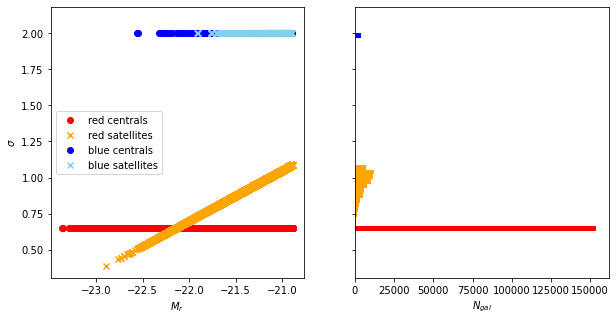

In [43]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

central_blue = (ia_kind == Galaxy.Kind.CENTRAL) & (ia_color == Galaxy.Color.BLUE)
satellite_blue = (ia_kind == Galaxy.Kind.SATELLITE) & (ia_color == Galaxy.Color.BLUE)

central_red = (ia_kind == Galaxy.Kind.CENTRAL) & (ia_color == Galaxy.Color.RED)
satellite_red = (ia_kind == Galaxy.Kind.SATELLITE) & (ia_color == Galaxy.Color.RED)


ix=0

ax[ix].scatter(cat.iloc[central_red].subaru_r_abs_mag, cat.iloc[central_red].sigma, label='red centrals', c='r', marker='o')
ax[ix].scatter(cat.iloc[satellite_red].subaru_r_abs_mag, cat.iloc[satellite_red].sigma, label='red satellites', c='orange', marker='x')
ax[ix].scatter(cat.iloc[central_blue].subaru_r_abs_mag, cat.iloc[central_blue].sigma, label='blue centrals', c='b', marker='o')
ax[ix].scatter(cat.iloc[satellite_blue].subaru_r_abs_mag, cat.iloc[satellite_blue].sigma, label='blue satellites', c='skyblue', marker='x')

ax[ix].legend(loc='center left')
ax[ix].set_xlabel('$M_r$')
ax[ix].set_ylabel('$\sigma$')

ix=1

sig_bins = np.linspace(0.5,2.1,50)

ax[ix].hist(cat.iloc[central_red].sigma, bins=sig_bins, color='r',orientation='horizontal')
ax[ix].hist(cat.iloc[satellite_red].sigma, bins=sig_bins, color='orange',orientation='horizontal')
ax[ix].hist(cat.iloc[central_blue].sigma, bins=sig_bins, color='b',orientation='horizontal')
ax[ix].hist(cat.iloc[satellite_blue].sigma, bins=sig_bins, color='skyblue',orientation='horizontal')

ax[ix].set_xlabel('$N_{gal}$')


### randomize initial orientations

In [44]:
Ar,Cr = ia.randomize(Ag, Cg, cat['sigma'].values)

In [45]:
ax_gal_rand = Ar[:, 0]
ay_gal_rand = Ar[:, 1]
az_gal_rand = Ar[:, 2]
cx_gal_rand = Cr[:, 0]
cy_gal_rand = Cr[:, 1]
cz_gal_rand = Cr[:, 2]

# 5) get 2D ellipticities of projected 3D galaxies

### set up input vectors for IA model

In [46]:
vg = np.array([
    cat['x_gal'].values,
    cat['y_gal'].values,
    cat['z_gal'].values,
]).T

Ag = np.array([
    ax_gal_rand,
    ay_gal_rand,
    az_gal_rand,
]).T

Cg = np.array([
    cx_gal_rand,
    cy_gal_rand,
    cz_gal_rand,
]).T

qg = cat['q_gal'].values.T
sg = cat['s_gal'].values.T

In [47]:
cat['eps1_gal'], cat['eps2_gal'] = ia.ellipticity(vg, qg, sg, Ag, Cg)

# 6) validation

### projected 2D axis ratios

In [48]:
eps_abs = (cat['eps1_gal']**2 + cat['eps2_gal']**2)**0.5
cat['q_proj'] = (1-eps_abs) / (1+eps_abs)

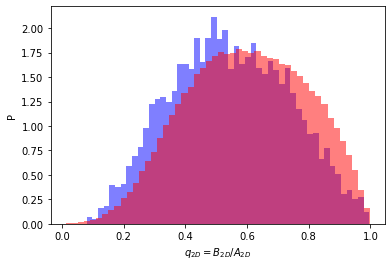

In [49]:
blues = ia_color == Galaxy.Color.BLUE
reds = ia_color == Galaxy.Color.RED

plt.hist(cat.iloc[blues].q_proj, bins=50, density=True, alpha=0.5, color='b')
plt.hist(cat.iloc[reds].q_proj, bins=50, density=True, alpha=0.5, color='r')

plt.xlabel(r'$q_{2D} = B_{2D}/A_{2D}$')
plt.ylabel('P')
plt.show()